In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from PIL import Image
import torchvision.transforms as transforms

/home/vamsi/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("osunlp/MagicBrush")

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['img_id', 'turn_index', 'source_img', 'mask_img', 'instruction', 'target_img'],
        num_rows: 8807
    })
    dev: Dataset({
        features: ['img_id', 'turn_index', 'source_img', 'mask_img', 'instruction', 'target_img'],
        num_rows: 528
    })
})

In [4]:
print(ds['train'][0].keys())

dict_keys(['img_id', 'turn_index', 'source_img', 'mask_img', 'instruction', 'target_img'])


In [5]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Typical ImageNet normalization
])

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [7]:
import io
class MagicBrushDataset(Dataset):
    def __init__(self, split='train', fraction=1.0):
        if fraction<1.0:
            split = f"{split}[:{int(fraction * 100)}%]"
        self.dataset = load_dataset("osunlp/MagicBrush", split=split)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve the item from the dataset
        item = self.dataset[idx]

        # Process text: encode with BERT tokenizer and get embeddings
        text = item['instruction']
        tokens = tokenizer(text, return_tensors='pt', padding='max_length', max_length=128, truncation=True)
        with torch.no_grad():
            text_embedding = bert_model(**tokens).last_hidden_state[:, 0, :]  # CLS token embedding (768-dimensional)

        if isinstance(item['source_img'], Image.Image):  # Already a PIL image
            image = item['source_img'].convert('RGB')
        else:
            raise ValueError(f"Unexpected type for 'source_img': {type(item['source_img'])}")
        
        # Apply image transformations
        image = image_transform(image)

        # Process binary mask (convert to binary tensor)
        if isinstance(item['mask_img'], Image.Image):  # Check if already a PIL image
            mask = item['mask_img'].convert('L')
        else:
            raise ValueError(f"Unexpected type for 'mask': {type(item['mask'])}")

        mask = transforms.Resize((224, 224))(mask)
        mask = transforms.ToTensor()(mask)
        mask = (mask > 0).float()  # Binary mask
        mask = mask.squeeze(0)
        return text_embedding.squeeze(0), image, mask

In [8]:
train_dataset = MagicBrushDataset(split='train', fraction=0.5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=False)

In [9]:
test_dataset = MagicBrushDataset(split='dev')
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=False)

In [10]:
print(len(train_dataset), len(test_dataset))

4404 528


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [12]:
# reference : https://www.restack.io/p/cross-attention-answer-sequence-to-sequence-cat-ai

In [13]:
class CrossAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(CrossAttention, self).__init__()
        self.heads = heads
        self.embed_size = embed_size
        self.values = nn.Linear(embed_size, embed_size, bias=False)
        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, x, context):
        N = x.shape[0]  # Number of samples
        value_len, key_len, query_len = context.shape[1], context.shape[1], x.shape[1]
        
        # Split embedding into multiple heads
        values = self.values(context).view(N, value_len, self.heads, self.embed_size // self.heads)
        keys = self.keys(context).view(N, key_len, self.heads, self.embed_size // self.heads)
        queries = self.queries(x).view(N, query_len, self.heads, self.embed_size // self.heads)
                
        # Calculate attention scores
        energy = torch.einsum('nqhd,nkhd->nqhk', [queries, keys])
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        # Weighted sum of values
        out = torch.einsum('nqhk,nvhd->nqhd', [attention, values]).reshape(N, query_len, self.embed_size)
        return self.fc_out(out)

In [14]:

from torchvision.models import ResNet50_Weights

resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
for param in resnet.parameters():
    param.requires_grad = False

resnet = nn.Sequential(*list(resnet.children())[:-1])

projection_layer = nn.Linear(2048, 768)

class MaskPredictor(nn.Module):
    def __init__(self, resnet, projection_layer, embed_size=768, heads=8):
        super(MaskPredictor, self).__init__()
        self.resnet = resnet
        self.projection = projection_layer
        self.cross_attention = CrossAttention(embed_size, heads)  # Integrating Cross Attention
        
        # Mask prediction network
        self.mask_prediction_network =  nn.Sequential(
            # Step 1: Expand the channel dimension
            nn.ConvTranspose2d(768, 512, kernel_size=3, stride=2, padding=0),  # [32, 512, 3, 3]
            nn.ReLU(inplace=True),
            
            # Step 2: Further upsample with larger spatial dimensions
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=1),  # [32, 256, 7, 7]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2),  # [32, 128, 14, 14]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=1),   # [32, 64, 28, 28]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=1),    # [32, 32, 56, 56]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=0),    # [32, 16, 112, 112]
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=2),     # [32, 1, 224, 224]
            nn.Sigmoid()  # Assuming output needs to be normalized to [0, 1]
        )

        

    def forward(self, img, text):
        # Image feature extraction using ResNet
        features = self.resnet(img)
        features = features.view(features.size(0), -1)  # Flatten features
        img_features = self.projection(features)  # Project to the desired feature space
        

        # Cross-Attention: Text as query, Image features as key and value
        attention_out = self.cross_attention(text.unsqueeze(1), img_features.unsqueeze(1))  # (batch_size, seq_len, embed_size)
        

        # Prepare the output from attention mechanism
        attention_out = attention_out.view(attention_out.size(0), attention_out.size(2), 1, 1)# Add a dimension for the mask prediction network
        

        # Pass through the mask prediction network
        out = self.mask_prediction_network(attention_out)  # Shape: [batch_size, 1, 224, 224]
        
        return out.squeeze(1)  # Final output shape: [batch_size, 224, 224]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaskPredictor(resnet, projection_layer).to(device)
print(device)

cuda


# bce+iou #

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# Define IoU Loss
def iou_loss(pred, target, smooth=1e-6):
    # Flatten the predictions and targets to 1D for the intersection and union calculations
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = (pred * target).sum()
    union = (pred + target).sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    return 1 - iou  # IoU loss is 1 - IoU

# Define the combined loss (BCE + IoU)
class BCE_IOU_Loss(nn.Module):
    def __init__(self, lambda_bce=1.0, lambda_iou=1.0):
        super(BCE_IOU_Loss, self).__init__()
        self.bce = nn.BCELoss()
        self.lambda_bce = lambda_bce
        self.lambda_iou = lambda_iou

    def forward(self, pred, target):
        # Binary Cross-Entropy loss
        bce_loss = self.bce(pred, target)
        
        # IoU loss
        iou_losss = iou_loss(pred, target)
        
        # Combine BCE and IoU loss with the scaling factors
        loss = self.lambda_bce * bce_loss + self.lambda_iou * iou_losss
        return loss


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = MaskPredictor(resnet, projection_layer).to(device)

criterion = BCE_IOU_Loss()  # BCE+IOU Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for text_embedding, img, gt_mask in tqdm(train_loader):
        # Move input tensors to the device (GPU)
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]


        optimizer.zero_grad()

        # Forward pass
        pred_mask = model(img, text_embedding)  # Output shape: [batch_size, 1, 224, 224]
        
        
        # Compute combined loss (Dice + BCE)
        loss = criterion(pred_mask, gt_mask)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    if epoch%10==0:
        torch.save(model, f"crossattention_maskpredictor_bce+iou_epoch{epoch+1}.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


cuda


  0%|          | 0/138 [00:00<?, ?it/s]

100%|██████████| 138/138 [04:35<00:00,  1.99s/it]


Epoch [1/100], Loss: 0.7114


100%|██████████| 138/138 [04:40<00:00,  2.03s/it]


Epoch [2/100], Loss: 0.6476


100%|██████████| 138/138 [04:49<00:00,  2.10s/it]


Epoch [3/100], Loss: 0.6257


100%|██████████| 138/138 [04:58<00:00,  2.16s/it]


Epoch [4/100], Loss: 0.6322


100%|██████████| 138/138 [05:31<00:00,  2.40s/it]


Epoch [5/100], Loss: 0.6200


100%|██████████| 138/138 [04:50<00:00,  2.11s/it]


Epoch [6/100], Loss: 0.6196


100%|██████████| 138/138 [05:02<00:00,  2.19s/it]


Epoch [7/100], Loss: 0.6185


100%|██████████| 138/138 [05:09<00:00,  2.24s/it]


Epoch [8/100], Loss: 0.6105


100%|██████████| 138/138 [05:17<00:00,  2.30s/it]


Epoch [9/100], Loss: 0.6105


100%|██████████| 138/138 [05:11<00:00,  2.26s/it]


Epoch [10/100], Loss: 0.6075


100%|██████████| 138/138 [06:23<00:00,  2.78s/it]


Epoch [11/100], Loss: 0.6006


100%|██████████| 138/138 [06:04<00:00,  2.64s/it]


Epoch [12/100], Loss: 0.5966


100%|██████████| 138/138 [05:34<00:00,  2.42s/it]


Epoch [13/100], Loss: 0.5957


100%|██████████| 138/138 [05:25<00:00,  2.36s/it]


Epoch [14/100], Loss: 0.5926


 75%|███████▍  | 103/138 [04:08<00:45,  1.31s/it]

/tmp/ipykernel_263336/1869360454.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/home/vamsi/nlp/BCE+IOU/crossattention_maskpredictor_bce+iou_epoch91

tensor(0., device='cuda:0')


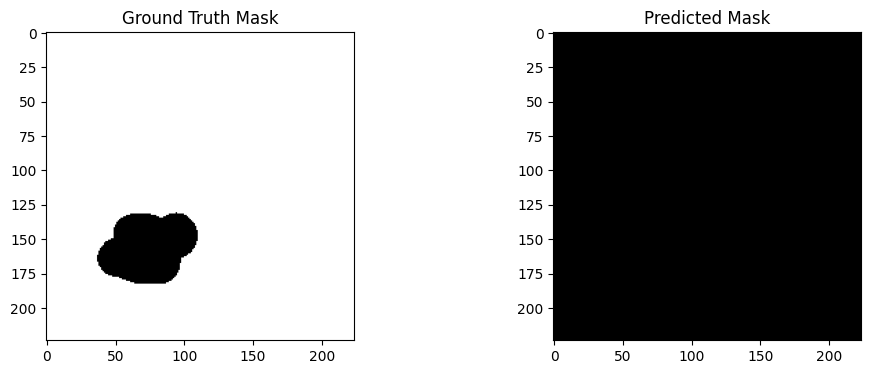

  1%|          | 1/138 [00:15<34:40, 15.19s/it]

tensor(0.3930, device='cuda:0')


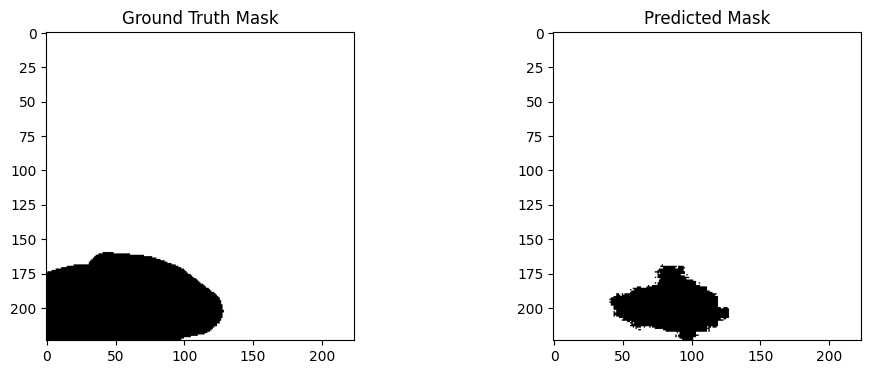

  1%|▏         | 2/138 [00:15<14:50,  6.54s/it]

tensor(0.0018, device='cuda:0')


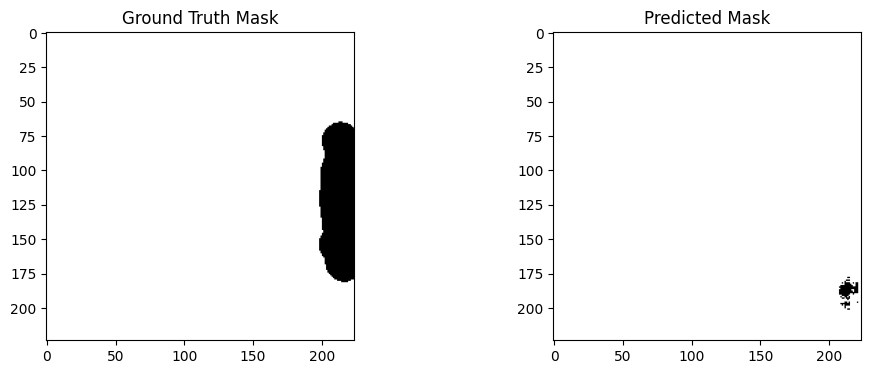

  2%|▏         | 3/138 [00:16<08:25,  3.74s/it]

tensor(0.1201, device='cuda:0')


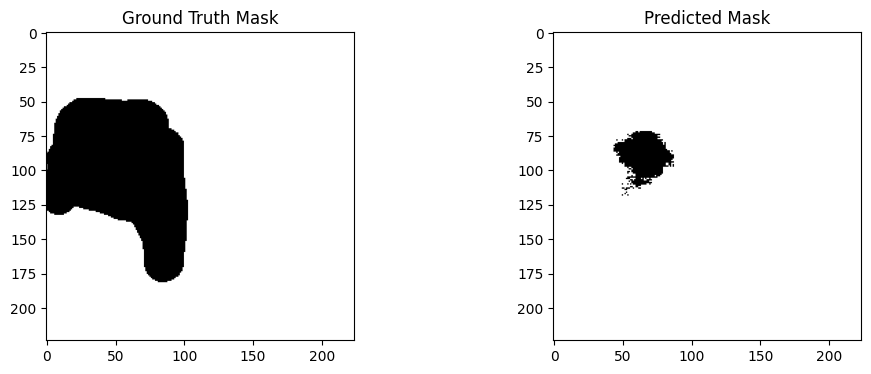

  3%|▎         | 4/138 [00:16<05:28,  2.45s/it]

tensor(0.8280, device='cuda:0')


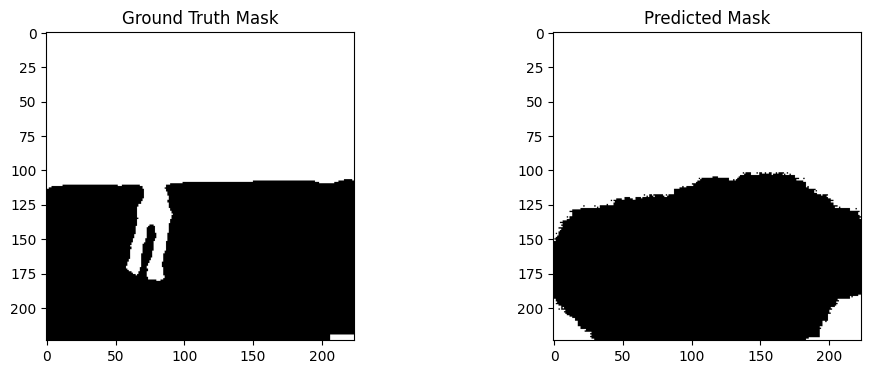

  4%|▎         | 5/138 [00:16<03:43,  1.68s/it]

tensor(0.0053, device='cuda:0')


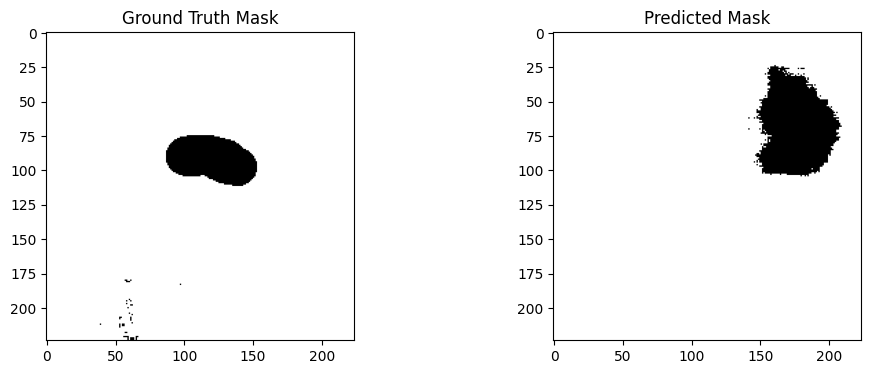

  4%|▍         | 6/138 [00:17<02:41,  1.22s/it]

tensor(0.1414, device='cuda:0')


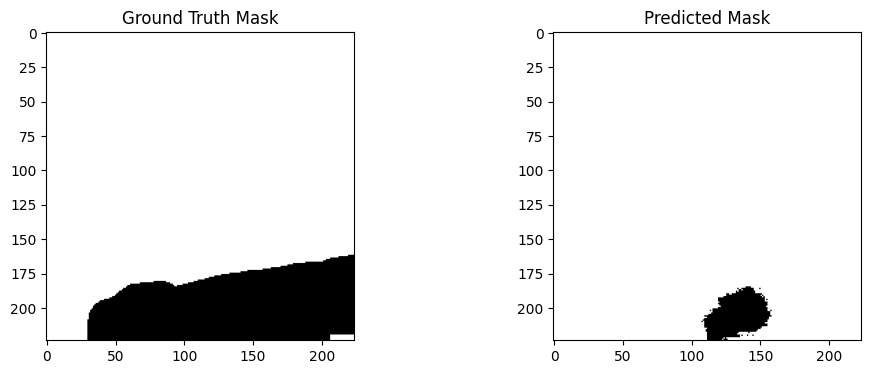

  5%|▌         | 7/138 [00:17<02:19,  1.07s/it]

tensor(0., device='cuda:0')


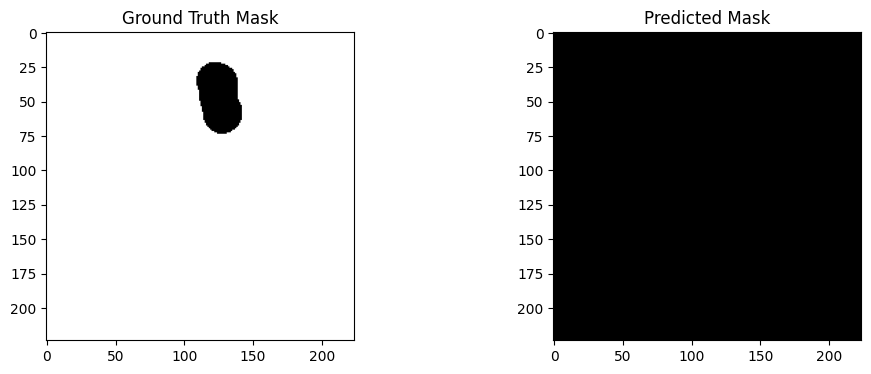

  6%|▌         | 8/138 [00:18<01:48,  1.20it/s]

tensor(0.1891, device='cuda:0')


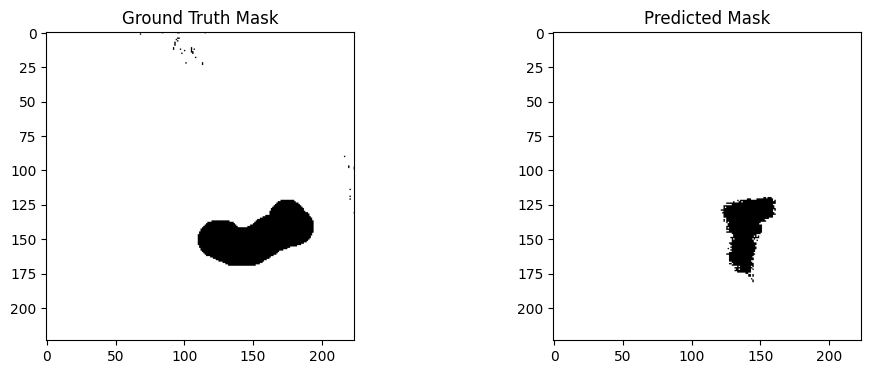

  7%|▋         | 9/138 [00:26<06:47,  3.16s/it]

tensor(0.8411, device='cuda:0')


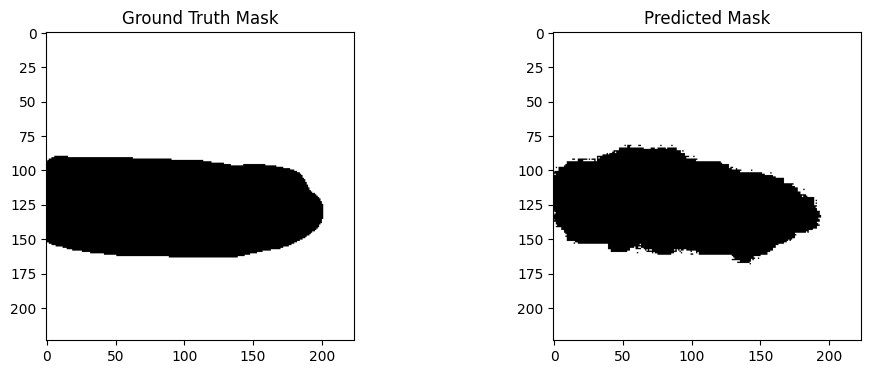

  7%|▋         | 10/138 [00:26<04:53,  2.29s/it]

tensor(0., device='cuda:0')


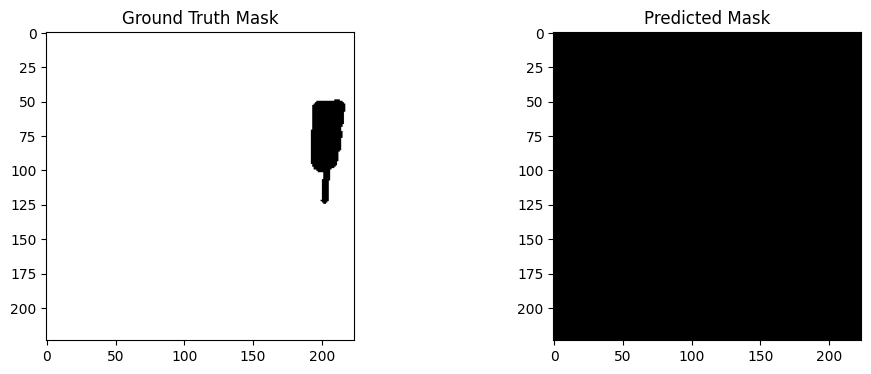

  8%|▊         | 11/138 [00:27<03:34,  1.69s/it]

tensor(0.8484, device='cuda:0')


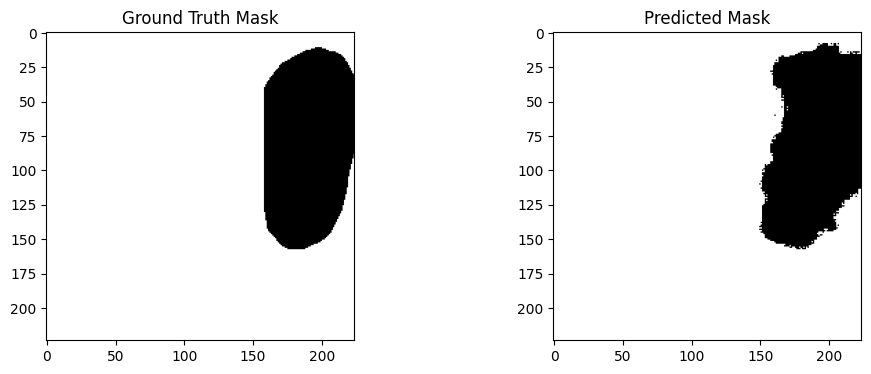

  9%|▊         | 12/138 [00:27<02:39,  1.26s/it]

tensor(0.8780, device='cuda:0')


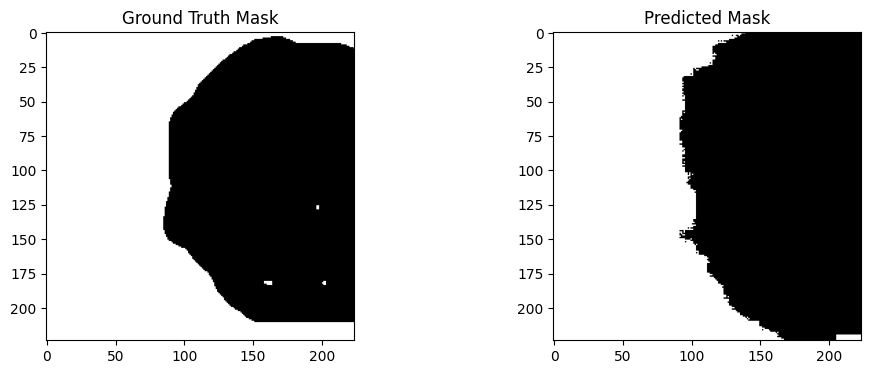

  9%|▉         | 13/138 [00:27<02:04,  1.01it/s]

tensor(0., device='cuda:0')


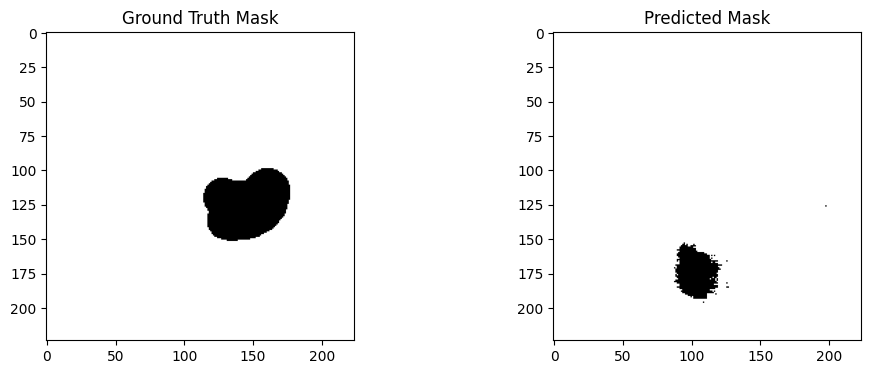

 10%|█         | 14/138 [00:28<01:36,  1.28it/s]

tensor(0.0050, device='cuda:0')


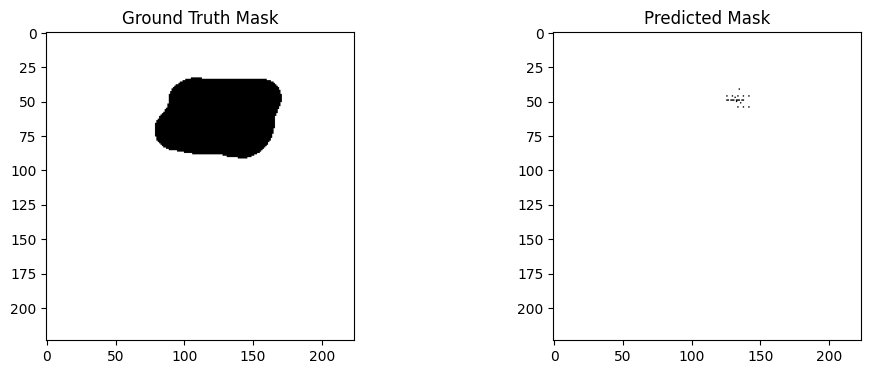

 11%|█         | 15/138 [00:28<01:20,  1.52it/s]

tensor(0., device='cuda:0')


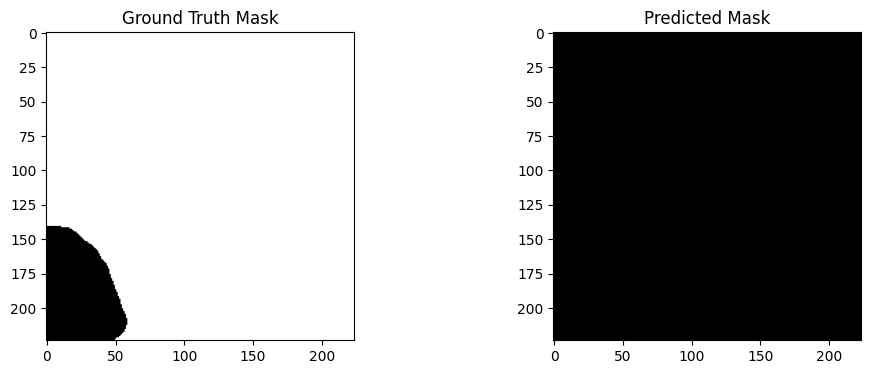

 12%|█▏        | 16/138 [00:28<01:10,  1.73it/s]

tensor(0., device='cuda:0')


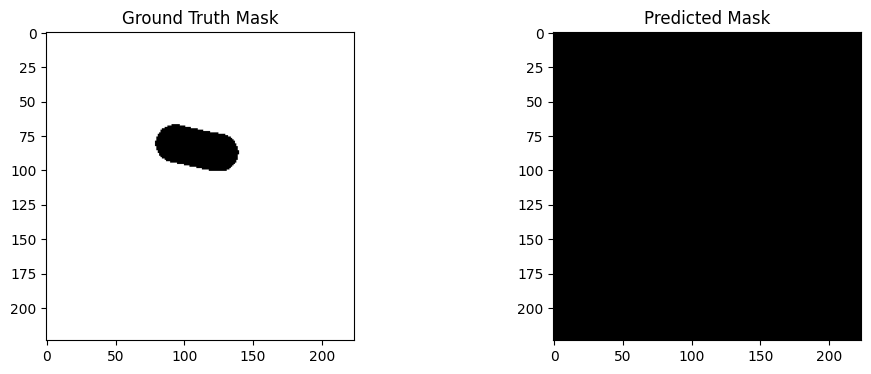

 12%|█▏        | 17/138 [00:41<08:22,  4.15s/it]

tensor(0., device='cuda:0')


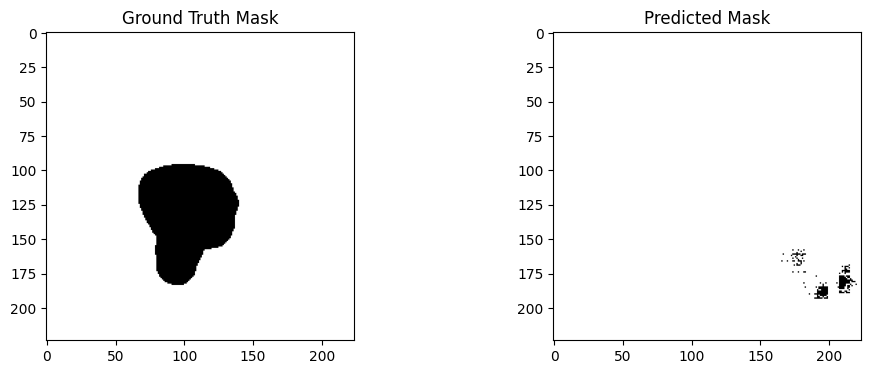

 13%|█▎        | 18/138 [00:41<06:02,  3.02s/it]

tensor(0., device='cuda:0')


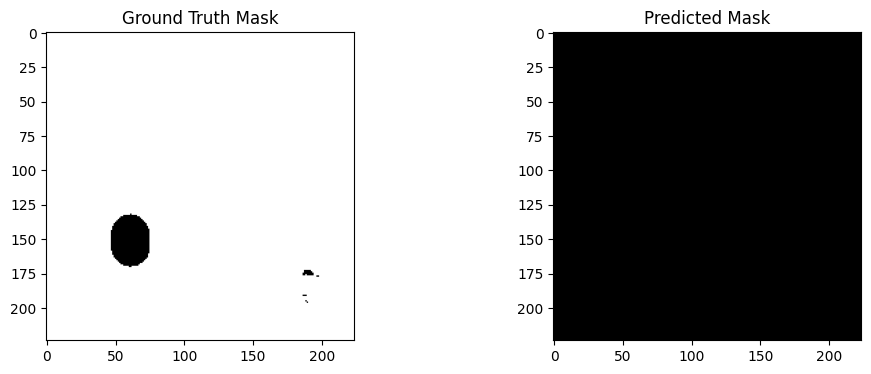

 14%|█▍        | 19/138 [00:42<04:24,  2.22s/it]

tensor(0., device='cuda:0')


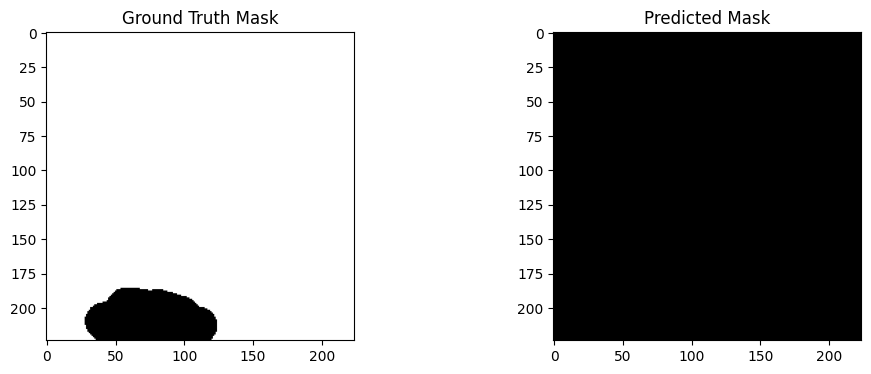

 16%|█▌        | 22/138 [00:42<01:47,  1.07it/s]

tensor(0.8782, device='cuda:0')
tensor(0.7413, device='cuda:0')
tensor(0.1748, device='cuda:0')


 17%|█▋        | 24/138 [00:42<01:07,  1.69it/s]

tensor(0.5115, device='cuda:0')


 20%|█▉        | 27/138 [00:55<03:48,  2.06s/it]

tensor(0.8004, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 21%|██        | 29/138 [00:56<02:28,  1.36s/it]

tensor(0., device='cuda:0')
tensor(0.1600, device='cuda:0')
tensor(0., device='cuda:0')


 22%|██▏       | 31/138 [00:56<01:39,  1.08it/s]

tensor(0.7453, device='cuda:0')
tensor(0.3784, device='cuda:0')


 25%|██▌       | 35/138 [01:10<03:23,  1.97s/it]

tensor(0., device='cuda:0')
tensor(0.0034, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 28%|██▊       | 39/138 [01:10<01:40,  1.01s/it]

tensor(0.0119, device='cuda:0')
tensor(0.1505, device='cuda:0')
tensor(0.0086, device='cuda:0')
tensor(0., device='cuda:0')


 31%|███       | 43/138 [01:26<03:25,  2.16s/it]

tensor(0.7246, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 34%|███▍      | 47/138 [01:26<01:42,  1.13s/it]

tensor(0., device='cuda:0')
tensor(0.5686, device='cuda:0')
tensor(0.0083, device='cuda:0')
tensor(0.3254, device='cuda:0')


 37%|███▋      | 51/138 [01:42<03:10,  2.19s/it]

tensor(0.4613, device='cuda:0')
tensor(0.1331, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.8640, device='cuda:0')


 40%|███▉      | 55/138 [01:43<01:35,  1.15s/it]

tensor(0.9174, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.6034, device='cuda:0')
tensor(0.9356, device='cuda:0')


 43%|████▎     | 59/138 [01:58<02:54,  2.20s/it]

tensor(0.8928, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3447, device='cuda:0')


 44%|████▍     | 61/138 [01:58<02:00,  1.57s/it]

tensor(0.8909, device='cuda:0')
tensor(0.0266, device='cuda:0')
tensor(0., device='cuda:0')


 46%|████▌     | 63/138 [01:59<01:24,  1.13s/it]

tensor(0., device='cuda:0')
tensor(0.9058, device='cuda:0')


 49%|████▊     | 67/138 [02:15<02:39,  2.24s/it]

tensor(0.5069, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5130, device='cuda:0')


 50%|█████     | 69/138 [02:15<01:50,  1.60s/it]

tensor(0.8283, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.6516, device='cuda:0')


 51%|█████▏    | 71/138 [02:15<01:16,  1.14s/it]

tensor(0.3975, device='cuda:0')
tensor(0., device='cuda:0')


 54%|█████▍    | 75/138 [02:31<02:23,  2.27s/it]

tensor(0.4109, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.2827, device='cuda:0')
tensor(0.7519, device='cuda:0')


 57%|█████▋    | 79/138 [02:33<01:18,  1.32s/it]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 60%|██████    | 83/138 [02:47<01:58,  2.16s/it]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 63%|██████▎   | 87/138 [02:50<01:07,  1.32s/it]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.6899, device='cuda:0')
tensor(0., device='cuda:0')


 66%|██████▌   | 91/138 [03:03<01:35,  2.03s/it]

tensor(0., device='cuda:0')
tensor(0.2565, device='cuda:0')
tensor(0.0338, device='cuda:0')
tensor(0., device='cuda:0')


 69%|██████▉   | 95/138 [03:05<00:51,  1.19s/it]

tensor(0.1426, device='cuda:0')
tensor(0.0103, device='cuda:0')
tensor(0.4393, device='cuda:0')
tensor(0.3579, device='cuda:0')


 72%|███████▏  | 99/138 [03:18<01:18,  2.00s/it]

tensor(0.5463, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.7638, device='cuda:0')
tensor(0.1007, device='cuda:0')


 75%|███████▍  | 103/138 [03:20<00:42,  1.21s/it]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.8820, device='cuda:0')


 78%|███████▊  | 107/138 [03:34<01:01,  2.00s/it]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5207, device='cuda:0')
tensor(0.3136, device='cuda:0')


 80%|████████  | 111/138 [03:36<00:33,  1.25s/it]

tensor(0.2226, device='cuda:0')
tensor(0.8217, device='cuda:0')
tensor(0.4116, device='cuda:0')
tensor(0.7270, device='cuda:0')


 83%|████████▎ | 115/138 [03:50<00:48,  2.10s/it]

tensor(0.9306, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0798, device='cuda:0')
tensor(0., device='cuda:0')


 86%|████████▌ | 119/138 [03:52<00:23,  1.23s/it]

tensor(0.2807, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4477, device='cuda:0')


 89%|████████▉ | 123/138 [04:05<00:28,  1.93s/it]

tensor(0.9051, device='cuda:0')
tensor(0.9021, device='cuda:0')
tensor(0.6156, device='cuda:0')
tensor(0., device='cuda:0')


 92%|█████████▏| 127/138 [04:06<00:11,  1.09s/it]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.2724, device='cuda:0')
tensor(0., device='cuda:0')


 95%|█████████▍| 131/138 [04:18<00:12,  1.83s/it]

tensor(0.0121, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 98%|█████████▊| 135/138 [04:19<00:02,  1.02it/s]

tensor(0., device='cuda:0')
tensor(0.1238, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.0015, device='cuda:0')


 99%|█████████▉| 137/138 [04:27<00:01,  1.87s/it]

tensor(0.7921, device='cuda:0')


100%|██████████| 138/138 [04:27<00:00,  1.94s/it]

tensor(0., device='cuda:0')
Average IoU: 0.2604


In [16]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the trained model
model = torch.load("/home/vamsi/nlp/BCE+IOU/crossattention_maskpredictor_bce+iou_epoch91.pth")
model.eval()

# Initialize IoU accumulator
iou_sum = 0.0
total_samples = 0

# Prediction loop for test data
with torch.no_grad():  # Disable gradient calculation for inference
    for i, (text_embedding, img, gt_mask) in enumerate(tqdm(test_loader)):
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]
        
        gt_masko=gt_mask.cpu()

        # Invert ground truth mask (black as foreground)
        gt_mask = 1 - gt_mask

        # Make predictions
        pred_mask = model(img, text_embedding)
        pred_mask = (pred_mask > 0.5).float()  # Binarize predictions
        pred_masko = pred_mask.cpu()
        pred_mask = 1 - pred_mask  # Invert predicted mask (black as foreground)
   
        

        # Calculate IoU for each sample in the batch
        intersection = (pred_mask * gt_mask).sum(dim=(1, 2))
        
        union = (pred_mask + gt_mask).clamp(0, 1).sum(dim=(1, 2))
        iou = intersection / (union + 1e-6)  # Add small value to avoid division by zero
        print(iou[0])

        iou_sum += iou.sum().item()  # Accumulate batch IoU
        total_samples += iou.size(0)  # Accumulate total number of samples


        # Visualization for the first 20 samples
        if i < 20:
            img = img.cpu()
            gt_mask = gt_mask.cpu()
            pred_mask = pred_mask.cpu()
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].imshow(gt_masko[0].squeeze(), cmap="gray")  # Show ground truth mask
            axes[0].set_title("Ground Truth Mask")
            axes[1].imshow(pred_masko[0].squeeze(), cmap="gray")  # Show predicted mask
            axes[1].set_title("Predicted Mask")
            plt.show()

# Calculate average IoU
average_iou = iou_sum / total_samples
print(f"Average IoU: {average_iou:.4f}")
